### Assignment 
1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

### Part 1
* Pull in data and load needed packages

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your .txt files are structured correctly and located in the specified directory
# Adjust the file paths as necessary

# Load the node and edge data
node_edge_path = "/Users/willberritt/Downloads/soc-political-retweet/soc-political-retweet.edges"
node_edge_data = pd.read_csv(node_edge_path, sep=',', header=None, names=['node', 'edge', 'weight'])

# Load the node and label data
node_label_path = "/Users/willberritt/Downloads/soc-political-retweet/soc-political-retweet.node_labels"
node_label_data = pd.read_csv(node_label_path, sep=',', header=None, names=['node', 'category'])

# Now, `node_edge_data` contains your node and edge information,
# and `node_label_data` contains your node and label information.

In [4]:
# Merge DataFrames
merged_data = node_edge_data.merge(node_label_data, left_on='node', right_on='node', how='left')

# Create the graph from merged data, assuming 'source' and 'target' are the edge columns
# and 'label' is the column with node labels
G = nx.from_pandas_edgelist(merged_data, 'node', 'edge', 'category')

# Add node labels as attributes
for _, row in merged_data.iterrows():
    G.nodes[row['node']]['category'] = row['category']

### Part 2
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality. 

In [5]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

In [6]:
# Add centrality measures to node attributes
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centrality')


### Part 3
* Compare your centrality measures across your categorical groups.
* 1 = Right | 2 = left
* This is in reference to left and right leaning tweets which have been classified in the dataset beforehand.

In [7]:
# Prepare data for comparison
nodes_data = pd.DataFrame(index=G.nodes())
nodes_data['category'] = pd.Series(nx.get_node_attributes(G, 'category'))
nodes_data['degree_centrality'] = pd.Series(nx.get_node_attributes(G, 'degree_centrality'))
nodes_data['eigenvector_centrality'] = pd.Series(nx.get_node_attributes(G, 'eigenvector_centrality'))
# Group by label and calculate mean centrality measures for comparison
grouped_comparison = nodes_data.groupby('category').mean()

print(grouped_comparison)

          degree_centrality  eigenvector_centrality
category                                           
1.0                0.000694                0.007330
2.0                0.000508                0.000369


In [8]:
from scipy.stats import ttest_ind

# Separate centrality measures by category
category1 = nodes_data[nodes_data['category'] == 1]
category2 = nodes_data[nodes_data['category'] == 2]

# Perform t-tests
ttest_degree = ttest_ind(category1['degree_centrality'], category2['degree_centrality'])
ttest_eigenvector = ttest_ind(category1['eigenvector_centrality'], category2['eigenvector_centrality'])

print('T-test for Degree Centrality:', ttest_degree)
print('T-test for Eigenvector Centrality:', ttest_eigenvector)

T-test for Degree Centrality: TtestResult(statistic=5.074944369984493, pvalue=3.987483043664765e-07, df=6284.0)
T-test for Eigenvector Centrality: TtestResult(statistic=26.26638005856125, pvalue=2.2773919339220664e-144, df=6284.0)


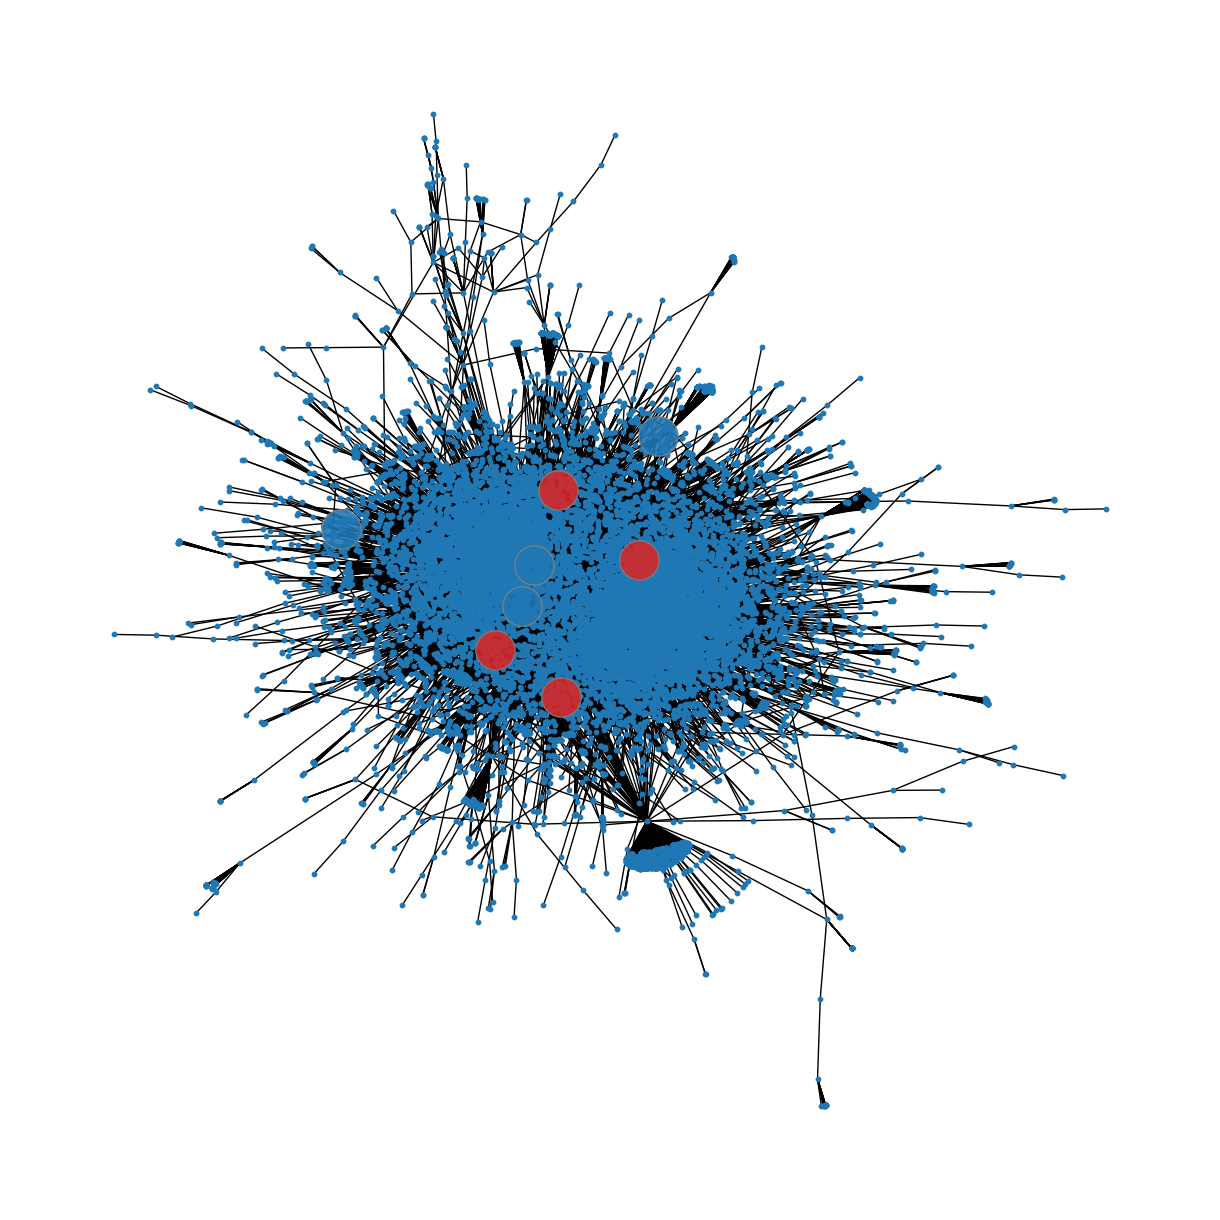

In [9]:
# Plot the graph
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=10)
nx.draw_networkx_nodes(G, pos, nodelist=[0, 1, 2, 3], node_color="tab:red", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[4, 5, 6, 7], node_color="tab:blue", **options)

In [10]:
# Take 3000 random rows from the dataset
merge_sample = merged_data.sample(n=3000, random_state=1)
G_2 = nx.from_pandas_edgelist(merge_sample, 'node', 'edge', 'category', create_using=nx.DiGraph)
# Proceed with your analysis using `random_rows` DataFrame

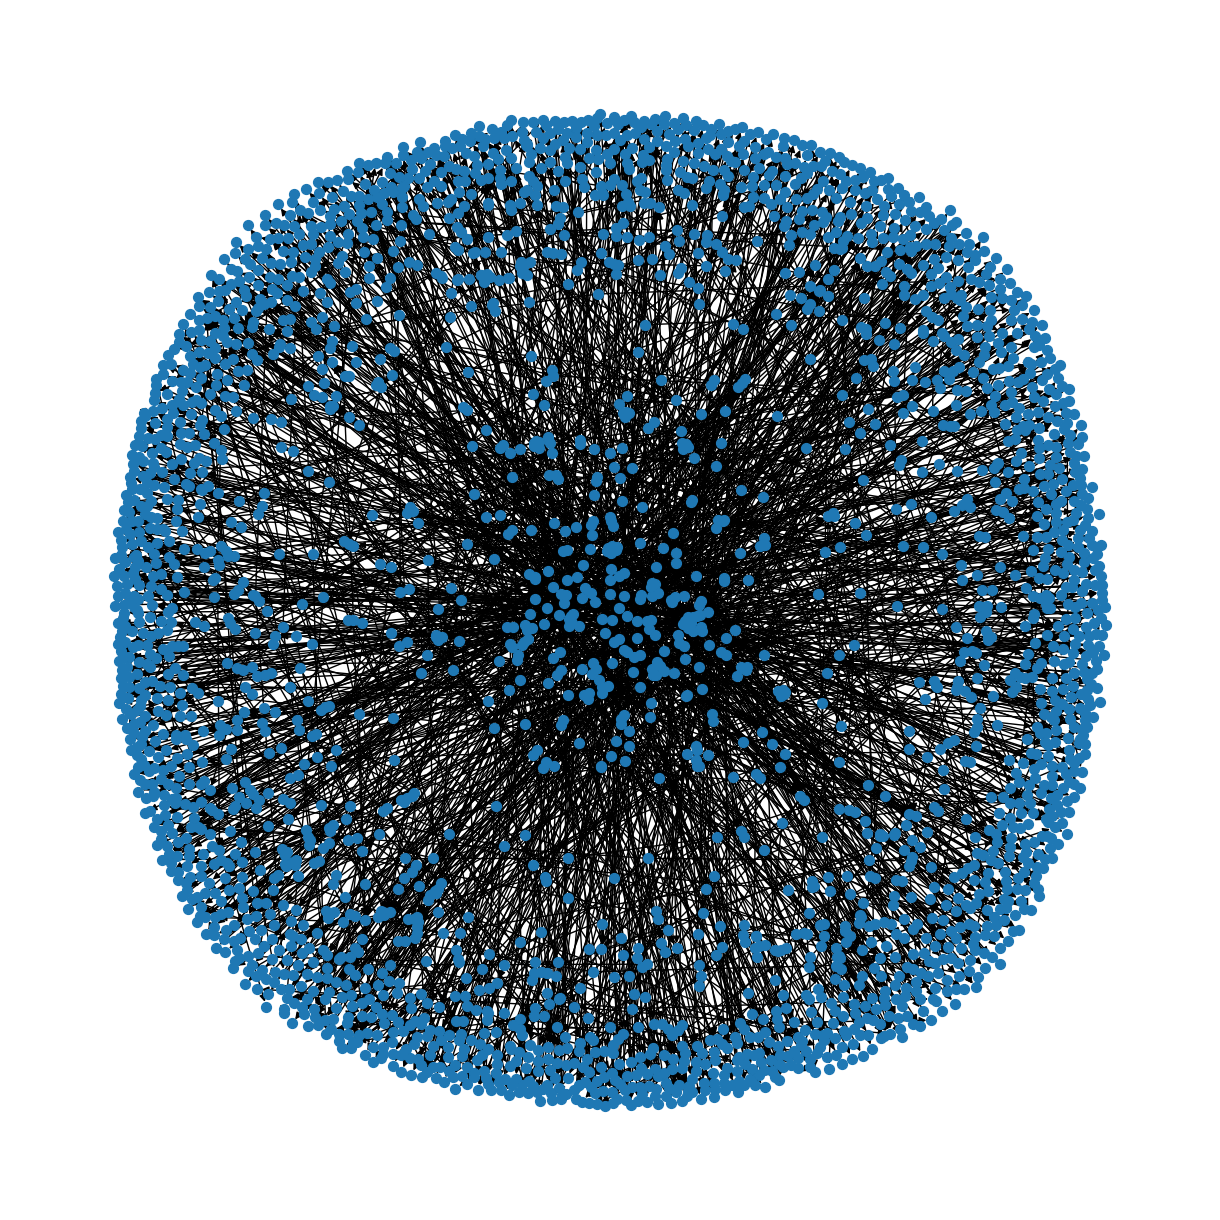

In [11]:
# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_2)
nx.draw(G_2, pos, node_size=50)

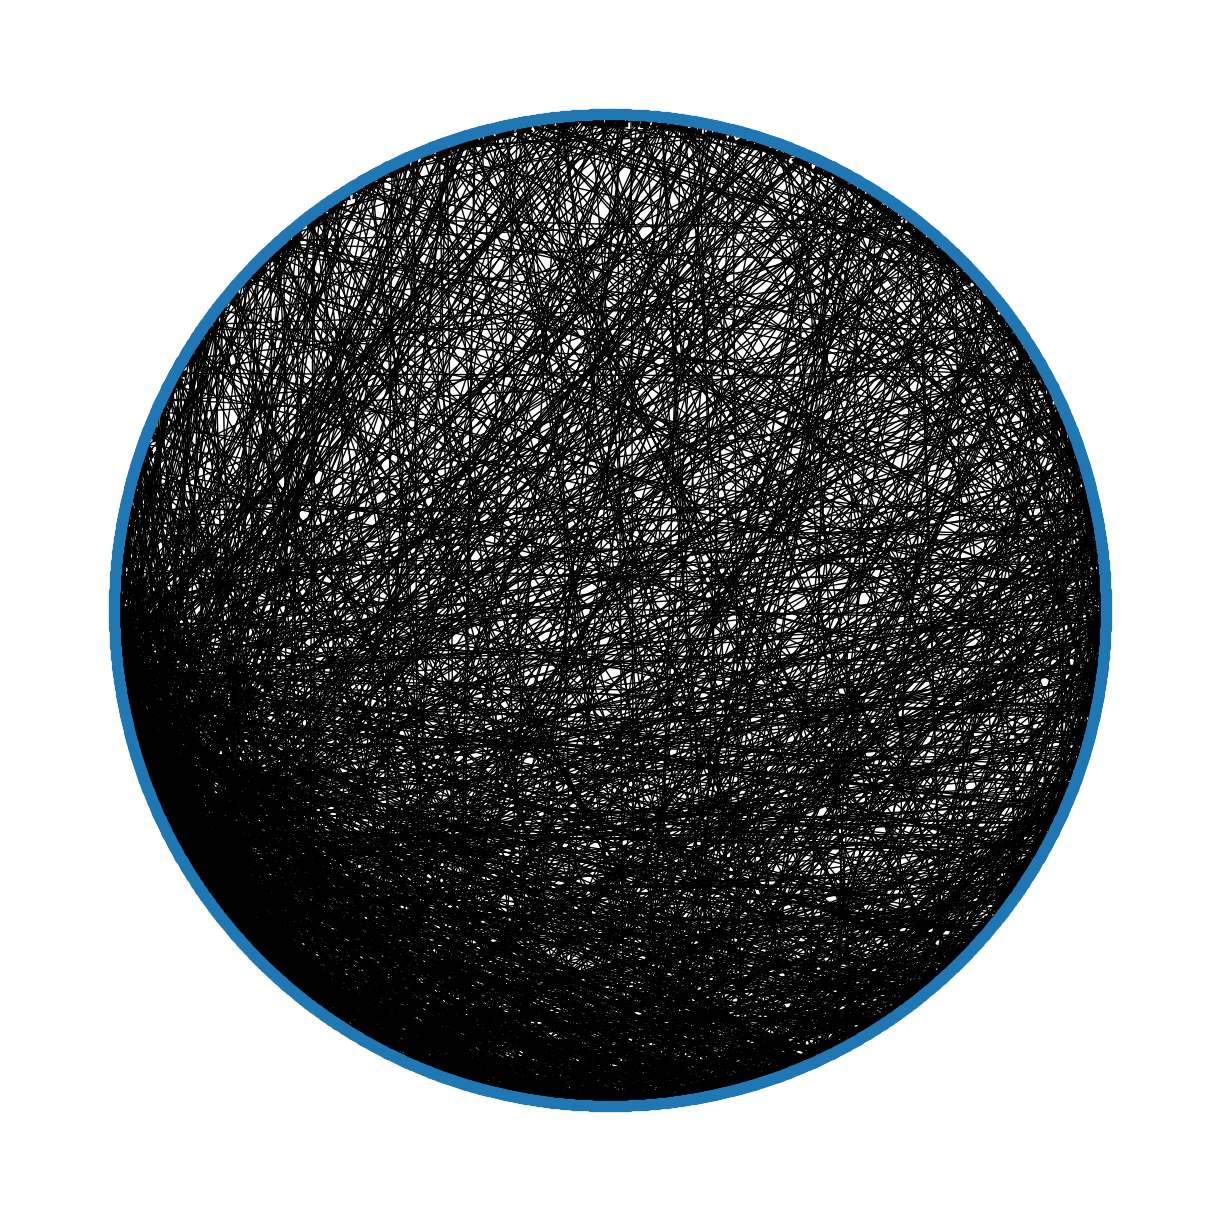

In [12]:
# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.shell_layout(G_2)
nx.draw(G_2, pos, node_size=50)

In [13]:
# Take 3000 random rows from the dataset
merge_sample = merged_data.sample(n=1000, random_state=1)
G_3 = nx.from_pandas_edgelist(merge_sample, 'node', 'edge', 'category', create_using=nx.DiGraph)
# Proceed with your analysis using `random_rows` DataFrame

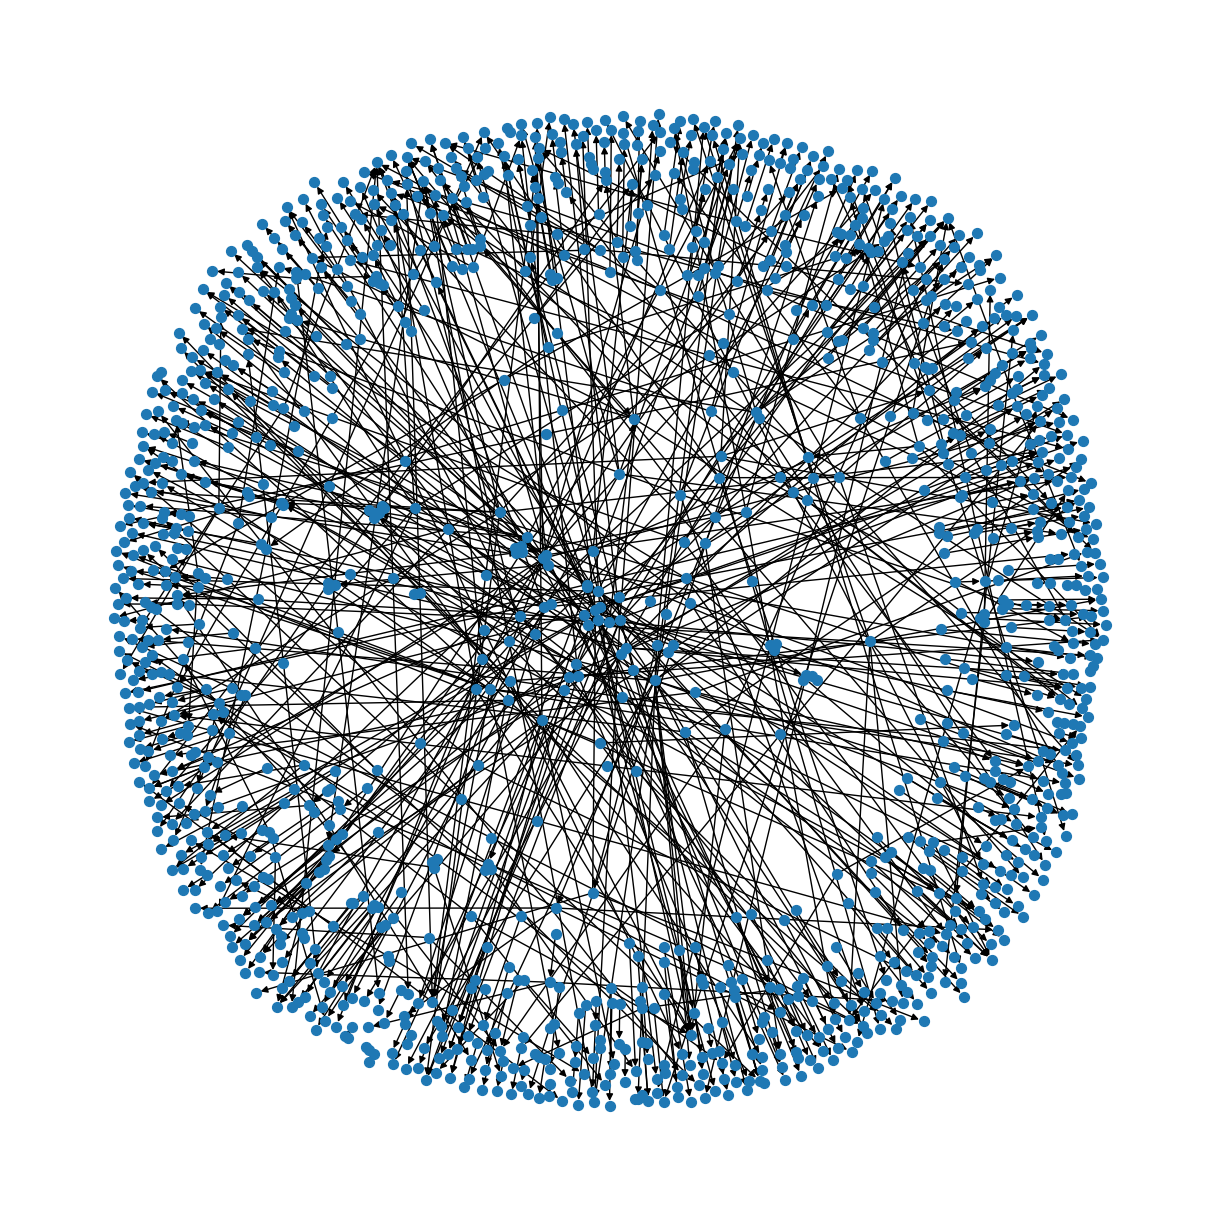

In [14]:
# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_3)
nx.draw(G_3, pos, node_size=50)

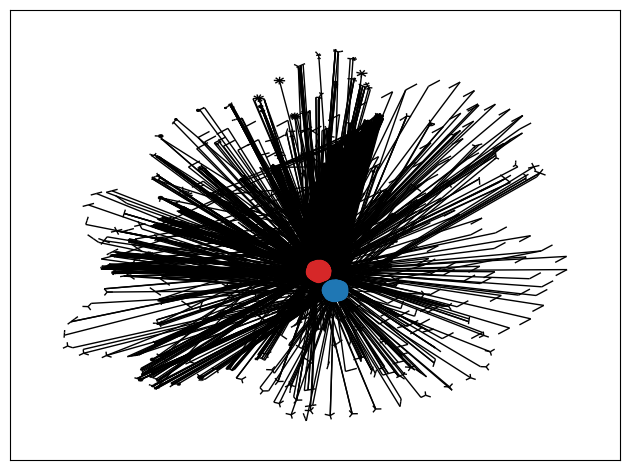

In [15]:
# Detect communities
communities = nx.community.greedy_modularity_communities(G)

# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(supergraph, scale=50, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))

# Nodes colored by cluster
colors = ("tab:blue","tab:red")
for nodes, clr in zip(communities, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=list(nodes), node_color=clr, node_size=100)
nx.draw_networkx_edges(G, pos=pos)

plt.tight_layout()
plt.show()

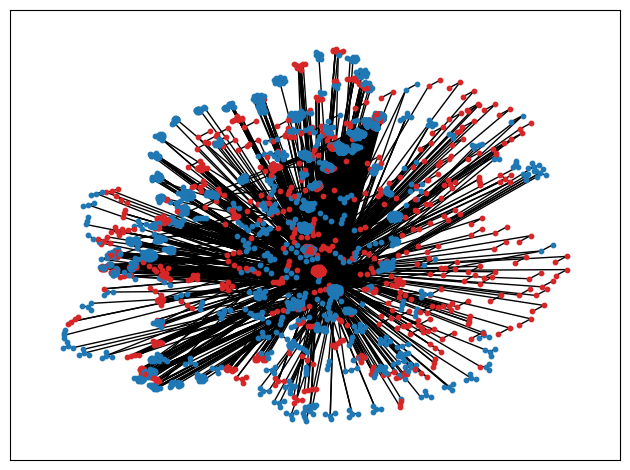

In [16]:
import pandas as pd

# Assuming 'node_label_path' is a string containing the file path to a CSV file
# The CSV file should have two columns without a header: the first for node identifiers and the second for categories
node_label_data = pd.read_csv(node_label_path, header=None)

# Convert the DataFrame to a dictionary mapping node identifiers to categories
node_categories = pd.Series(node_label_data[1].values, index=node_label_data[0]).to_dict()

# Continue with your existing logic for coloring nodes
category_colors = {1: "tab:red", 2: "tab:blue"}

for node in G.nodes():
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[node], node_color=category_colors[node_categories[node]], node_size=10)

nx.draw_networkx_edges(G, pos=pos)

plt.tight_layout()
plt.show()

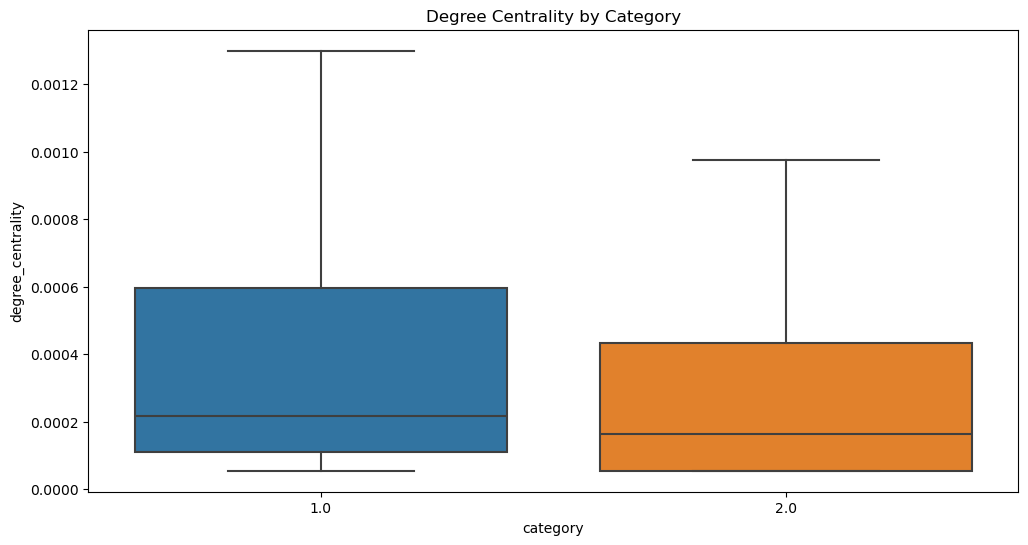

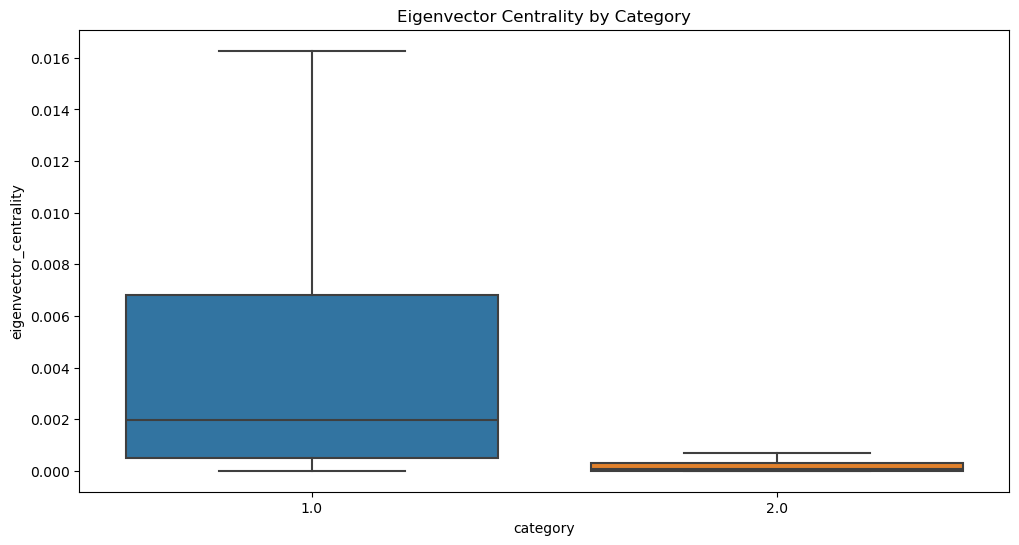

In [19]:
import seaborn as sns

# Box Plot for Degree Centrality without outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='degree_centrality', data=nodes_data, showfliers=False)
plt.title('Degree Centrality by Category')
plt.show()

# Box Plot for Eigenvector Centrality without outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='eigenvector_centrality', data=nodes_data, showfliers=False)
plt.title('Eigenvector Centrality by Category')
plt.show()
